# CIFAR-10 Image Classification Training Notebook

This notebook implements the training pipeline for CIFAR-10 image classification using PyTorch.

## Overview
- Model architecture loading and configuration
- Data loading and preprocessing
- Training loop with early stopping
- Model evaluation and visualization
---
### Key Features
- **Model Architecture**: Custom CNN/MLP with modern design patterns
- **Data Augmentation**: Mixup and Cutout for improved generalization
- **Optimization**: Adam/SGD with momentum and learning rate scheduling
- **Regularization**: BatchNorm, Dropout, and Label Smoothing
- **Training**: Early stopping and model checkpointing
- **Visualization**: Training metrics and sample predictions
---
## Requirements
- PyTorch
- torchvision
- numpy
- matplotlib
- seaborn
---

_Developed by Pavlo Borysov — June 2025_

🔗 [Project Repository on GitHub](https://github.com/ayri77/CIFAR10-Torch-Classifier)

In [1]:
# Uncomment to install dependencies if running in Colab
# !pip install torch torchvision matplotlib seaborn

### Libraries and environment

#### 📦 Standard & project setup

In [2]:
# Standard library imports
import sys
import os
import json
from pathlib import Path

# Add project root to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

# Project imports
from utils.paths import MODELS_DIR, DATA_DIR, ARCHITECTURES_DIR
from core.cifar10_classifier import CIFAR10Classifier
import config

# suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

#### 🔁 Reproducibility

In [3]:
# Utility imports
from utils.utils import set_seed, set_deterministic, load_architecture

# Set random seed and deterministic behavior
set_seed(config.SEED)
set_deterministic(
    deterministic=config.DETERMINISTIC,
    benchmark=config.BENCHMARK # torch.backends.cudnn.benchmark = True may speed up training if input sizes are fixed
)

🔧 Setting seed: 42


#### 🧠 Core imports (torch, torchvision)

In [4]:
# Deep learning imports
import torch
from torchvision import transforms

#### 📊 Visualization utilities

In [5]:
# Visualization imports
from utils.visualization import (
    show_random_samples,
    show_class_distribution,
    plot_training_history,
    plot_confusion_matrix,
    print_per_class_accuracy
)

#### Model Architecture Details (Sample)
The CNN architecture consists of:
1. **Convolutional Layers**:
   - 4 conv blocks with increasing channels (32→64→128→256)
   - 3x3 kernels with padding for spatial preservation
   - Max pooling for dimensionality reduction

2. **Fully Connected Layers**:
   - Two dense layers (512→256→10)
   - Batch normalization for stable training
   - Dropout for regularization (0.5, 0.3)

3. **Activation Functions**:
   - ReLU for non-linearity
   - Softmax for classification

#### Training Configuration
- **Optimizer**: SGD with momentum (0.9) and weight decay (0.0001)
- **Learning Rate**: 0.01 with ReduceLROnPlateau scheduler
- **Loss Function**: CrossEntropyLoss with label smoothing (0.1)
- **Training Duration**: 200 epochs with early stopping (patience=10)
- **Batch Size**: 256 for efficient training

#### Expected Results
- Validation accuracy: ~80% on CIFAR-10 validation set (10,000 images)
- Final model tested on Kaggle test set with accuracy ≈ 83.56%
- Training time: ~40 minutes
- Model checkpoints and metrics saved in the models directory

🔧 Using config from: `architectures/cnn_mixup_cutout_SGD.json`

In [6]:
model_name = "cnn_mixup_cutout_SGD"
with open(os.path.join(ARCHITECTURES_DIR, f"{model_name}.json")) as f:
    import pprint; pprint.pprint(json.load(f))

{'activation_fn': 'ReLU',
 'augmentation': {'cutout_size': 8, 'mixup_alpha': 0.4, 'mode': 'both'},
 'conv_layers': [{'kernel_size': 3,
                  'out_channels': 32,
                  'padding': 1,
                  'pool': True,
                  'stride': 1},
                 {'kernel_size': 3,
                  'out_channels': 64,
                  'padding': 1,
                  'pool': True,
                  'stride': 1},
                 {'kernel_size': 3,
                  'out_channels': 128,
                  'padding': 1,
                  'pool': True,
                  'stride': 1},
                 {'kernel_size': 3,
                  'out_channels': 256,
                  'padding': 1,
                  'pool': True,
                  'stride': 1}],
 'criterion': {'kwargs': {'label_smoothing': 0.1}, 'name': 'CrossEntropyLoss'},
 'dropout_rates': [0.5, 0.3],
 'fc_layers': [512, 256],
 'grayscale': False,
 'lr_scheduler': {'kwargs': {'cooldown': 0,
                 

### Loading Model Architecture

In [7]:
# Model configuration
model_name = "cnn_mixup_cutout_SGD"
metrics_path = os.path.join(MODELS_DIR, model_name, f"{model_name}_metrics.json")

# Load model architecture and configuration
(
    model_class,
    model_kwargs,
    activation_fn_name,
    optimizer_cfg,
    criterion_cfg,
    lr_scheduler_cfg,
    augmentation,
    grayscale
) = load_architecture(model_name, base_dir=ARCHITECTURES_DIR)

# Override activation function if needed
activation_fn_name = "ReLU"

# === Training hyperparameters unpack ===
optimizer_name = optimizer_cfg["name"]
optimizer_kwargs = optimizer_cfg["kwargs"]
criterion_name = criterion_cfg["name"]
criterion_kwargs = criterion_cfg["kwargs"]
lr_scheduler_name = lr_scheduler_cfg["name"]
lr_scheduler_kwargs = lr_scheduler_cfg["kwargs"]

# === Training runtime settings ===
NUM_EPOCHS = 200
PATIENCE = 10

### Dataset Information
CIFAR-10 is a benchmark dataset containing:
- 60,000 32x32 color images
- 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck)
- 50,000 training images and 10,000 test images
- Balanced class distribution

### Data loading and train/test set preparation

In [8]:
# Data loading and preprocessing
from utils.data_utils import (
    compute_mean_std,
    get_transforms,
    load_cifar10_datasets,
    split_train_val,
    create_loaders,
    get_dataset_info
)

# Load raw dataset for visualization
raw_dataset, _ = load_cifar10_datasets(
    data_dir=DATA_DIR,
    transform=transforms.ToTensor(),
    subset="train"
)
class_names = raw_dataset.classes

# Handle grayscale conversion if needed
if grayscale:
    transform_gs = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])

# Load training subset (raw) to compute dataset-wide mean and std
mean_std_dataset, _ = load_cifar10_datasets(
    data_dir=DATA_DIR,
    transform=transform_gs if grayscale else transforms.ToTensor(),
    subset="train"
)

📥 Downloading/loading CIFAR-10 datasets to c:\Users\pbori\Documents\ML AI Courses\Homework\CIFAR10_Torch_Classifier\data... Loading train dataset
Files already downloaded and verified
✅ Loaded training samples: 50000
📥 Downloading/loading CIFAR-10 datasets to c:\Users\pbori\Documents\ML AI Courses\Homework\CIFAR10_Torch_Classifier\data... Loading train dataset
Files already downloaded and verified
✅ Loaded training samples: 50000


#### 🔍 Compute mean and std of CIFAR-10 for normalization

In [9]:
# Compute dataset statistics
mean, std = compute_mean_std(mean_std_dataset)
print(f"📊 Dataset statistics:")
print(f"✅ Mean: {mean}, Std: {std}")

📊 Computing mean and std...
✅ Mean: [0.4913996756076813, 0.48215851187705994, 0.4465310275554657], Std: [0.24703219532966614, 0.24348489940166473, 0.2615877091884613]
📊 Dataset statistics:
✅ Mean: tensor([0.4914, 0.4822, 0.4465]), Std: tensor([0.2470, 0.2435, 0.2616])


#### 🧪 Apply augmentation and grayscale transforms

The transformation pipeline includes:

- `RandomCrop(32, padding=4)`
- `ColorJitter(...)`
- `HorizontalFlip`, `Rotation`, `Affine`
- `Resize` to ensure consistent input shape
- `Cutout(size=8)` for occlusion augmentation
- `Normalize(mean, std)`

In [10]:
# Create data transforms
train_transform = get_transforms(
    mean=mean,
    std=std,
    augmentation=augmentation,
    grayscale=grayscale
)

# Load with transformations
train_dataset, _ = load_cifar10_datasets(
    data_dir=DATA_DIR, 
    transform=train_transform, 
    subset="train"
)

🧪 Creating transform pipeline...
🧪 Transform pipeline:
  └─ RandomCrop(size=(32, 32), padding=4)
  └─ ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(-0.1, 0.1))
  └─ RandomHorizontalFlip(p=0.5)
  └─ RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
  └─ RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1))
  └─ Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
  └─ ToTensor()
  └─ Cutout(size=8)
  └─ Normalize(mean=[0.4913996756076813, 0.48215851187705994, 0.4465310275554657], std=[0.24703219532966614, 0.24348489940166473, 0.2615877091884613])
📥 Downloading/loading CIFAR-10 datasets to c:\Users\pbori\Documents\ML AI Courses\Homework\CIFAR10_Torch_Classifier\data... Loading train dataset
Files already downloaded and verified
✅ Loaded training samples: 50000


#### 📦 Split dataset into train/validation sets

In [11]:
# Load and split dataset
train_subset, val_subset = split_train_val(
    train_dataset,
    split_ratio=config.SPLIT_RATIO
)

# Create data loaders
train_loader, val_loader, _ = create_loaders(
    train_subset=train_subset,
    val_subset=val_subset,
    test_dataset=None,
    batch_size=config.BATCH_SIZE,
    num_workers=4
)

🔀 Splitting dataset with ratio 0.80...
✅ Train size: 40000, Validation size: 10000
📦 Creating data loaders with batch size 256...
✅ Data loaders ready.


### Data Exploration and Visualization

In [12]:
# Data Exploration and Visualization
print("\n📊 Data Exploration:")
print(f"Total training samples: {len(train_subset)}")
print(f"Total validation samples: {len(val_subset)}")
print(f"Number of classes: {len(class_names)}")
print(f"Image shape: {train_subset[0][0].shape}")
print(f"Class names: {class_names}")


📊 Data Exploration:
Total training samples: 40000
Total validation samples: 10000
Number of classes: 10
Image shape: torch.Size([3, 32, 32])
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


🔍 Below we compare original images with augmented versions using current transform pipeline (e.g. Cutout + Crop + Flip).


🖼️ Random samples from the dataset:


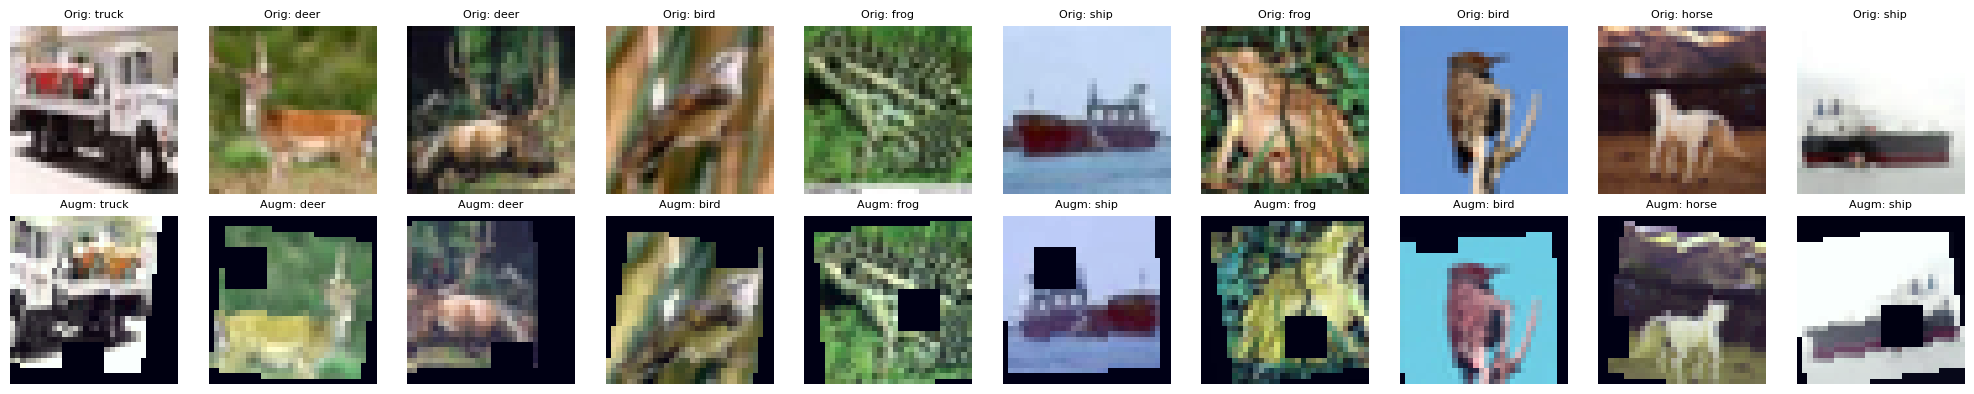

In [13]:
# Visualize random samples from the dataset
print("\n🖼️ Random samples from the dataset:")
show_random_samples(raw_dataset, train_dataset, class_names, n=10)


📈 Class distribution in the dataset:


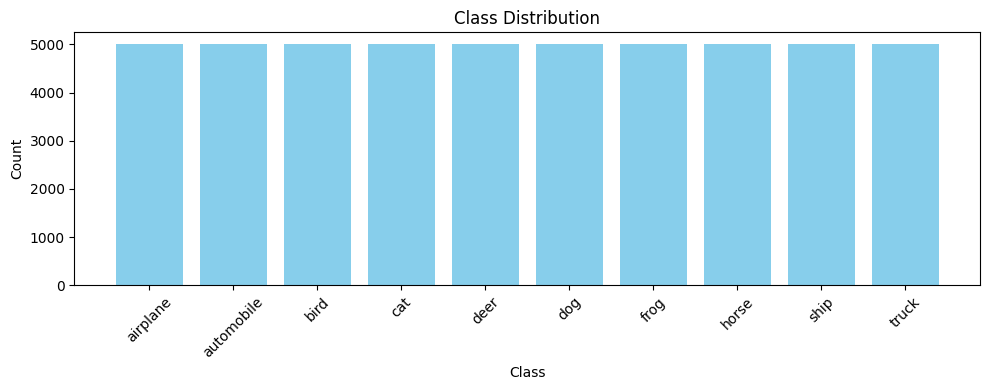

In [14]:
# Show class distribution
print("\n📈 Class distribution in the dataset:")
show_class_distribution(raw_dataset, class_names)

## Model Building and Training

### Model Initialization

In [15]:
# Model building and compilation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_shape, num_classes = get_dataset_info(train_dataset)

if grayscale:
    input_shape = (1, input_shape[1], input_shape[2])

model_cls = CIFAR10Classifier(
    name=model_name,
    model_class=model_class,
    model_kwargs=model_kwargs,
    input_shape=input_shape,
    num_classes=num_classes,
    activation_fn_name=activation_fn_name,
    optimizer_name=optimizer_name,
    optimizer_kwargs=optimizer_kwargs,
    criterion_name=criterion_name,
    criterion_kwargs=criterion_kwargs,
    device=device,
    mean=mean.tolist(),
    std=std.tolist(),
    lr_scheduler_name=lr_scheduler_name,
    lr_scheduler_kwargs=lr_scheduler_kwargs,
    augmentation=augmentation,
    grayscale=grayscale
)
model_cls.build_model()
model_cls.compile()

print(f"🧮 Total trainable parameters: {sum(p.numel() for p in model_cls.model.parameters() if p.requires_grad):,}")

🔍 Extracting dataset info...
✅ Input shape: torch.Size([3, 32, 32]), Number of classes: 10
🧮 Total trainable parameters: 1,048,586


The summary below shows the structure of the CNN model, including all convolutional and fully connected layers.

In [16]:
model_cls.summary()

Layer (type:depth-idx)                   Output Shape              Param #
CIFAR10_CNN                              [1, 10]                   --
├─Sequential: 1-1                        [1, 256, 2, 2]            --
│    └─Conv2d: 2-1                       [1, 32, 32, 32]           896
│    └─BatchNorm2d: 2-2                  [1, 32, 32, 32]           64
│    └─ReLU: 2-3                         [1, 32, 32, 32]           --
│    └─MaxPool2d: 2-4                    [1, 32, 16, 16]           --
│    └─Conv2d: 2-5                       [1, 64, 16, 16]           18,496
│    └─BatchNorm2d: 2-6                  [1, 64, 16, 16]           128
│    └─ReLU: 2-7                         [1, 64, 16, 16]           --
│    └─MaxPool2d: 2-8                    [1, 64, 8, 8]             --
│    └─Conv2d: 2-9                       [1, 128, 8, 8]            73,856
│    └─BatchNorm2d: 2-10                 [1, 128, 8, 8]            256
│    └─ReLU: 2-11                        [1, 128, 8, 8]            --
│   

### Training Process

In [18]:
# Start training
model_cls.train(
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=NUM_EPOCHS,
    patience=PATIENCE,
    verbose=True,
    log_tensorboard=True
)


🚀 Training configuration:
🧱 Architecture:       CIFAR10_CNN
📦 Model name:        cnn_mixup_cutout_SGD
📐 Input shape:       torch.Size([3, 32, 32])
🔷 Conv layers:
[   {   'kernel_size': 3,
        'out_channels': 32,
        'padding': 1,
        'pool': True,
        'stride': 1},
    {   'kernel_size': 3,
        'out_channels': 64,
        'padding': 1,
        'pool': True,
        'stride': 1},
    {   'kernel_size': 3,
        'out_channels': 128,
        'padding': 1,
        'pool': True,
        'stride': 1},
    {   'kernel_size': 3,
        'out_channels': 256,
        'padding': 1,
        'pool': True,
        'stride': 1}]
🔢 FC layers:          [512, 256]
🎛 Dropout rates:      [0.5, 0.3]
⚙️ Activation:        ReLU
📈 Optimizer:         SGD
   {'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0001}
🎯 Criterion:         CrossEntropyLoss
   {'label_smoothing': 0.1}
🎯 Lr scheduler:      ReduceLROnPlateau
   {   'cooldown': 0,
    'factor': 0.5,
    'min_lr': 1e-06,
    'mode': '

In [19]:
print(f"🔎 View TensorBoard logs: tensorboard --logdir=runs/{model_cls.name}")

🔎 View TensorBoard logs: tensorboard --logdir=runs/cnn_mixup_cutout_SGD


## Results and Analysis

### Training History Visualization

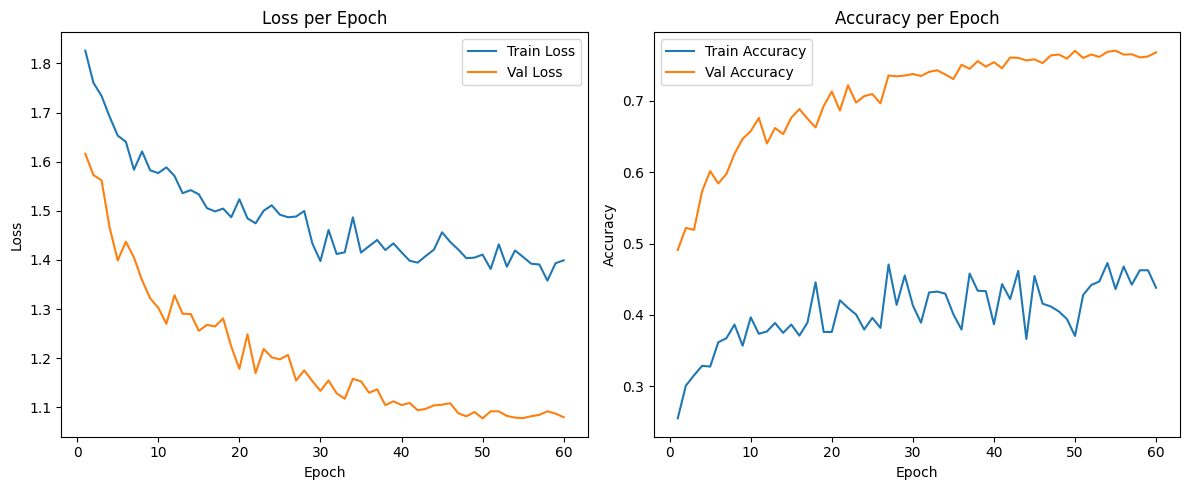

In [20]:
# Load and plot training history
with open(metrics_path, 'r') as f:    
    history = json.load(f)

if not history:
    print("⚠️ No training history found.")
else:
    plot_training_history(history)

In [21]:
# Print training summary
best_epoch = max(history, key=lambda x: x['val_accuracy'])
print("\n📊 Training Summary:")
print(f"Best validation accuracy: {best_epoch['val_accuracy']:.4f} (Epoch {best_epoch['epoch']})")
print(f"Best validation loss: {best_epoch['val_loss']:.4f}")
print(f"Training time: {sum(h['epoch_time'] for h in history):.2f} seconds")
print(f"Total epochs: {len(history)}")
print(f"Final learning rate: {best_epoch.get('learning_rate', 'N/A')}")


📊 Training Summary:
Best validation accuracy: 0.7704 (Epoch 55)
Best validation loss: 1.0779
Training time: 1699.44 seconds
Total epochs: 60
Final learning rate: 0.000625


#### Model Evaluation

Validation loss: 1.0757, accuracy: 0.7679

📊 Validation Results:
Overall accuracy: 0.7679


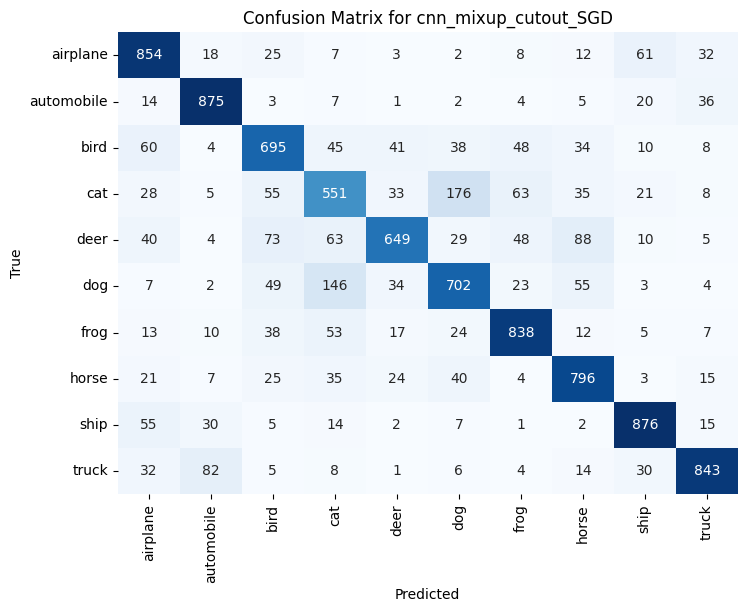

In [22]:
# Model evaluation
metrics = model_cls.evaluate(val_loader)
val_accuracy = metrics['accuracy']
print(f"\n📊 Validation Results:")
print(f"Overall accuracy: {val_accuracy:.4f}")

# Plot confusion matrix
plot_confusion_matrix(
    metrics["y_pred"],
    metrics["y_true"],
    class_names=class_names,
    model_name=model_name
)

#### Model Analysis

In [23]:
# Print per-class accuracy
print("\n📊 Per-class accuracy:")
print_per_class_accuracy(metrics["y_true"], metrics["y_pred"], class_names)

# Analyze training dynamics
train_acc = [h['train_accuracy'] for h in history]
val_acc = [h['val_accuracy'] for h in history]
train_loss = [h['train_loss'] for h in history]
val_loss = [h['val_loss'] for h in history]

# Calculate overfitting gap
overfitting_gap = max(train_acc) - max(val_acc)
print("\n🔍 Model Analysis:")
print(f"Overfitting gap: {overfitting_gap:.4f}")
print(f"Training accuracy range: {min(train_acc):.4f} - {max(train_acc):.4f}")
print(f"Validation accuracy range: {min(val_acc):.4f} - {max(val_acc):.4f}")

# Analyze learning rate changes
lr_changes = [h.get('learning_rate', None) for h in history if 'learning_rate' in h]
if lr_changes:
    print(f"\n📈 Learning rate changes:")
    print(f"Initial LR: {lr_changes[0]}")
    print(f"Final LR: {lr_changes[-1]}")
    print(f"Number of LR reductions: {len(set(lr_changes)) - 1}")

# Analyze convergence
convergence_epoch = next(
    (i for i, h in enumerate(history) 
     if h['val_accuracy'] >= 0.95 * max(val_acc)),
    None
)
if convergence_epoch is not None:
    print(f"\n⚡ Convergence Analysis:")
    print(f"Model reached 95% of best accuracy at epoch {convergence_epoch + 1}")
    print(f"Convergence time: {sum(h['epoch_time'] for h in history[:convergence_epoch + 1]):.2f} seconds")

# Save final results
results = {
    'model_name': model_name,
    'best_epoch': best_epoch['epoch'],
    'best_val_accuracy': best_epoch['val_accuracy'],
    'best_val_loss': best_epoch['val_loss'],
    'final_val_accuracy': val_accuracy,
    'training_time': sum(h['epoch_time'] for h in history),
    'total_epochs': len(history),
    'overfitting_gap': overfitting_gap,
    'convergence_epoch': convergence_epoch + 1 if convergence_epoch is not None else None,
    'learning_rate_changes': len(set(lr_changes)) - 1 if lr_changes else 0
}

results_path = os.path.join(MODELS_DIR, model_name, f"{model_name}_results.json")
with open(results_path, 'w') as f:
    json.dump(results, f, indent=4)
print(f"\n✅ Results saved to {results_path}")


📊 Per-class accuracy:
              precision    recall  f1-score   support

    airplane     0.7598    0.8356    0.7959      1022
  automobile     0.8438    0.9049    0.8733       967
        bird     0.7143    0.7070    0.7106       983
         cat     0.5931    0.5651    0.5788       975
        deer     0.8062    0.6432    0.7155      1009
         dog     0.6842    0.6849    0.6845      1025
        frog     0.8050    0.8240    0.8144      1017
       horse     0.7559    0.8206    0.7870       970
        ship     0.8431    0.8699    0.8563      1007
       truck     0.8664    0.8224    0.8438      1025

    accuracy                         0.7679     10000
   macro avg     0.7672    0.7678    0.7660     10000
weighted avg     0.7677    0.7679    0.7663     10000


🔍 Model Analysis:
Overfitting gap: -0.2976
Training accuracy range: 0.2550 - 0.4728
Validation accuracy range: 0.4911 - 0.7704

📈 Learning rate changes:
Initial LR: 0.01
Final LR: 0.0003125
Number of LR reductions: 5
